# Example 9: Cell Viability Measurement

In this notebook we normalize different fluorescent intensity signs to provide normalized cell viability measurement. For beginning let's start with two channels cases, that $I_1$ is high indicating low viability (negative/death signals), and $I_2$ is high for high viability (positive/live signals):

$$\text{Viability}(I_1,I_2) = \frac{1}{1+0.5(e^{-10\cdot(0.5-I_1)}+e^{-10\cdot(I_2-0.5)})}$$

We may generalize it to the formulation:
- ${I_1,I_2,...I_N}$ is the set of intensities of measurement channels.
- Positive signal indexed by the set $P$.
- Negative signal index by the set $N$.
- With pre-normalized channel range to $[0,1]$
Assume a similar exponential sensitivity for each channel, with a shift of 0.5 as the neutral value. Then the generalized viability function for any number of channels becomes:

$$\text{Viability}(I_1,I_2,...,I_N) = \frac{1}{1+\frac{1}{|P|+|N|}(\sum_{i\in P}e^{-10\cdot(I_i-0.5)}+\sum_{j\in N}e^{-10\cdot(0.5-I_j)})}$$
​
Where:

- $\sum_{i\in P}e^{-10\cdot(I_i-0.5)}$ sums the contributions of all positive channels (where higher intensity indicates greater viability).
- $\sum_{j\in N}e^{-10\cdot(0.5-I_j)}$ sums the contributions of all negative channels (where higher intensity indicates lower viability).
- $|P|$ and $|N|$ are the number of positive and negative channels, respectively.
- The scaling factor $\frac{1}{|P|+|N|}$ ensures that the viability function remains properly normalized across any number of channels.

This generalization ensures that signals from any number of channels, both positive and negative, are combined to produce a viability score between 0 and 1.

## Headers

In [1]:
import pandas as pd
import numpy as np
from cyto.postprocessing.sparse_to_sparse import *
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [2]:
tracks_gfp_df = pd.read_csv("/mnt/KIRPC602/DATA/UTSE/2023_10_03_Nyeso1_HCT116_framerate_10sec_flowrate_0p15mlperh_analysis/tracks/20231003_roi-5_0-2899_binT-1_cancer/tracks_remapped.csv")
tracks_gfp_df

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,1318.130348,0,CANCER,NaN,894,1000025,0.308649,910,919,219.029670
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,2169.971420,0,CANCER,NaN,895,1000028,0.609457,156,159,302.897436
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,1371.094849,0,CANCER,NaN,896,1000029,0.328590,50,51,181.500000
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,734.811983,0,CANCER,NaN,897,1000039,0.407693,291,291,153.859107
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,1617.135717,0,CANCER,NaN,900,1000040,0.222839,331,331,99.465257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,964.564149,2899,CANCER,NaN,49976,2900011772,2.789058,66,81,265.257576
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,284.310961,2899,CANCER,NaN,49979,2900014130,0.448188,63,81,113.333333
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,215.072645,2899,CANCER,NaN,49980,2900014124,11.110681,20,80,197.150000
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,1069.895284,2899,CANCER,NaN,49989,2900016071,0.294653,63,64,115.365079


In [3]:
tracks_pi_df = pd.read_csv("/mnt/KIRPC602/DATA/UTSE/2023_10_03_Nyeso1_HCT116_framerate_10sec_flowrate_0p15mlperh_analysis/tracks/20231003_roi-5_0-2899_binT-1_cancer/tracks_pi_remapped.csv")
tracks_pi_df

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,2.638476,0,CANCER,NaN,894,1000025,0.308649,910,919,219.029670
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,13.639799,0,CANCER,NaN,895,1000028,0.609457,156,159,302.897436
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,2.964320,0,CANCER,NaN,896,1000029,0.328590,50,51,181.500000
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,2.680904,0,CANCER,NaN,897,1000039,0.407693,291,291,153.859107
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,3.453746,0,CANCER,NaN,900,1000040,0.222839,331,331,99.465257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,2.920804,2899,CANCER,NaN,49976,2900011772,2.789058,66,81,265.257576
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,2.704959,2899,CANCER,NaN,49979,2900014130,0.448188,63,81,113.333333
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,2.070935,2899,CANCER,NaN,49980,2900014124,11.110681,20,80,197.150000
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,6.469963,2899,CANCER,NaN,49989,2900016071,0.294653,63,64,115.365079


In [4]:
tracks_gfp_df_norm = intensity_norm(tracks_gfp_df,channel="mean", percentile=1)
tracks_gfp_df_norm

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,mean_norm
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,0,CANCER,NaN,894,1000025,0.308649,910,919,219.029670,0.365458
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,0,CANCER,NaN,895,1000028,0.609457,156,159,302.897436,0.526268
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,0,CANCER,NaN,896,1000029,0.328590,50,51,181.500000,0.531541
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,0,CANCER,NaN,897,1000039,0.407693,291,291,153.859107,0.105581
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,0,CANCER,NaN,900,1000040,0.222839,331,331,99.465257,0.379686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,2899,CANCER,NaN,49976,2900011772,2.789058,66,81,265.257576,0.426187
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,2899,CANCER,NaN,49979,2900014130,0.448188,63,81,113.333333,0.031290
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,2899,CANCER,NaN,49980,2900014124,11.110681,20,80,197.150000,0.026127
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,2899,CANCER,NaN,49989,2900016071,0.294653,63,64,115.365079,0.476570


In [5]:
tracks_pi_df_norm = intensity_norm(tracks_pi_df,channel="mean", percentile=1)
tracks_pi_df_norm

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,mean_norm
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,0,CANCER,NaN,894,1000025,0.308649,910,919,219.029670,0.001968
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,0,CANCER,NaN,895,1000028,0.609457,156,159,302.897436,0.021796
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,0,CANCER,NaN,896,1000029,0.328590,50,51,181.500000,0.002392
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,0,CANCER,NaN,897,1000039,0.407693,291,291,153.859107,0.001072
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,0,CANCER,NaN,900,1000040,0.222839,331,331,99.465257,0.003584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,2899,CANCER,NaN,49976,2900011772,2.789058,66,81,265.257576,0.006442
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,2899,CANCER,NaN,49979,2900014130,0.448188,63,81,113.333333,0.005717
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,2899,CANCER,NaN,49980,2900014124,11.110681,20,80,197.150000,0.004220
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,2899,CANCER,NaN,49989,2900016071,0.294653,63,64,115.365079,0.024622


In [6]:
track_gfp_df_norm = tracks_gfp_df_norm.rename(
    columns={
        "mean": "GFP mean",
        "median": "GFP median",
        "sd": "GFP sd",
        "mean_norm": "GFP mean norm"
    }
)

track_pi_df_norm = tracks_pi_df_norm.rename(
    columns={
        "mean": "PI mean",
        "median": "PI median",
        "sd": "PI sd",
        "mean_norm": "PI mean norm"
    }
)

In [7]:
track = left_table_merge(track_gfp_df_norm, track_pi_df_norm, on='label')
track

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,GFP mean norm,PI mean,PI median,PI sd,PI mean norm
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,1000025,0.308649,910,919,219.029670,0.365458,110.882114,113.144531,2.638476,0.001968
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,1000028,0.609457,156,159,302.897436,0.526268,119.688525,113.144531,13.639799,0.021796
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,1000029,0.328590,50,51,181.500000,0.531541,111.070312,113.144531,2.964320,0.002392
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,1000039,0.407693,291,291,153.859107,0.105581,110.484076,113.144531,2.680904,0.001072
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,1000040,0.222839,331,331,99.465257,0.379686,111.600000,113.144531,3.453746,0.003584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,2900011772,2.789058,66,81,265.257576,0.426187,112.869231,133.328125,2.920804,0.006442
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,2900014130,0.448188,63,81,113.333333,0.031290,112.547170,133.328125,2.704959,0.005717
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,2900014124,11.110681,20,80,197.150000,0.026127,111.882353,133.328125,2.070935,0.004220
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,2900016071,0.294653,63,64,115.365079,0.476570,120.943503,133.328125,6.469963,0.024622


## Viability Calculation

In [8]:
track_via = cal_viability(track,pos_cols=["GFP mean norm"], neg_cols=["PI mean norm"])
track

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,GFP mean norm,PI mean,PI median,PI sd,PI mean norm,viability
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,0.308649,910,919,219.029670,0.365458,110.882114,113.144531,2.638476,0.001968,0.342075
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,0.609457,156,159,302.897436,0.526268,119.688525,113.144531,13.639799,0.021796,0.720107
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,0.328590,50,51,181.500000,0.531541,111.070312,113.144531,2.964320,0.002392,0.730890
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,0.407693,291,291,153.859107,0.105581,110.484076,113.144531,2.680904,0.001072,0.037285
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,0.222839,331,331,99.465257,0.379686,111.600000,113.144531,3.453746,0.003584,0.374705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,2.789058,66,81,265.257576,0.426187,112.869231,133.328125,2.920804,0.006442,0.487898
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,0.448188,63,81,113.333333,0.031290,112.547170,133.328125,2.704959,0.005717,0.018092
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,11.110681,20,80,197.150000,0.026127,111.882353,133.328125,2.070935,0.004220,0.017198
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,0.294653,63,64,115.365079,0.476570,120.943503,133.328125,6.469963,0.024622,0.611127


## Plot Viability as Function of Time

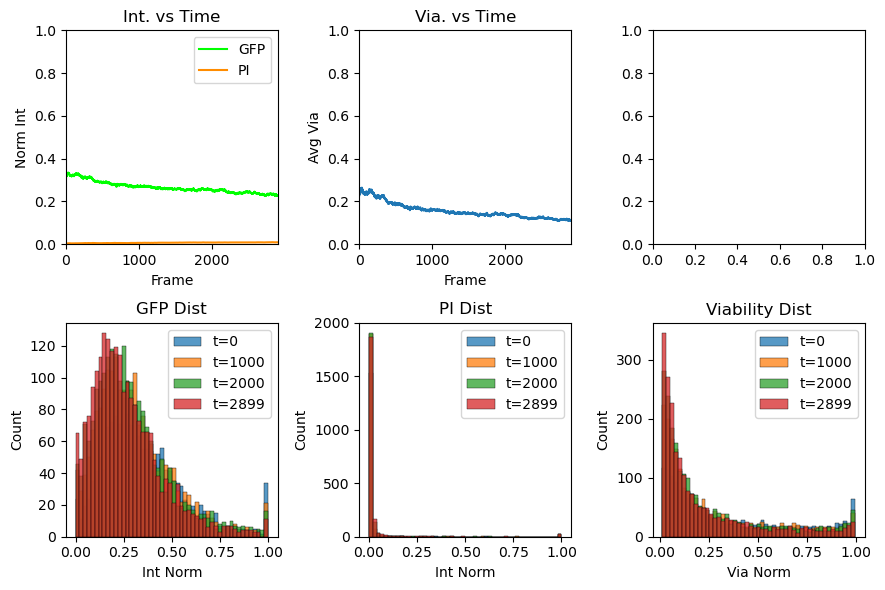

In [9]:
fig, axs = plt.subplots(2,3,figsize=(9,6))

axs[0,0].plot(track_via.groupby('frame')['GFP mean norm'].median(), label="GFP", c="lime")
axs[0,0].plot(track_via.groupby('frame')['PI mean norm'].median(), label="PI", c="darkorange")
axs[0,0].set_xlim(0,track_via["frame"].max() )
axs[0,0].set_ylim(0,1 )
axs[0,0].set_ylabel("Norm Int")
axs[0,0].set_xlabel("Frame")
axs[0,0].set_title("Int. vs Time")
axs[0,0].legend()

axs[0,1].plot(track_via.groupby('frame')['viability'].median())
axs[0,1].set_ylabel("Avg Via")
axs[0,1].set_xlabel("Frame")
axs[0,1].set_title("Via. vs Time")
axs[0,1].set_xlim(0,track_via["frame"].max() )
axs[0,1].set_ylim(0,1 )

axs[1,0].set_title("GFP Dist")
sns.histplot(track_via[track_via["frame"]==0]['GFP mean norm'], binwidth=0.02, label="t=0", ax=axs[1,0])
sns.histplot(track_via[track_via["frame"]==1000]['GFP mean norm'], binwidth=0.02, label="t=1000", ax=axs[1,0])
sns.histplot(track_via[track_via["frame"]==2000]['GFP mean norm'], binwidth=0.02, label="t=2000", ax=axs[1,0])
sns.histplot(track_via[track_via["frame"]==2899]['GFP mean norm'], binwidth=0.02, label="t=2899", ax=axs[1,0])
axs[1,0].legend()
axs[1,0].set_xlabel("Int Norm")

axs[1,1].set_title("PI Dist")
sns.histplot(track_via[track_via["frame"]==0]['PI mean norm'], binwidth=0.02, label="t=0", ax=axs[1,1])
sns.histplot(track_via[track_via["frame"]==1000]['PI mean norm'], binwidth=0.02, label="t=1000", ax=axs[1,1])
sns.histplot(track_via[track_via["frame"]==2000]['PI mean norm'], binwidth=0.02, label="t=2000", ax=axs[1,1])
sns.histplot(track_via[track_via["frame"]==2899]['PI mean norm'], binwidth=0.02, label="t=2899", ax=axs[1,1])
axs[1,1].legend()
axs[1,1].set_xlabel("Int Norm")

axs[1,2].set_title("Viability Dist")
sns.histplot(track_via[track_via["frame"]==0]['viability'], binwidth=0.02, label="t=0", ax=axs[1,2])
sns.histplot(track_via[track_via["frame"]==1000]['viability'], binwidth=0.02, label="t=1000", ax=axs[1,2])
sns.histplot(track_via[track_via["frame"]==2000]['viability'], binwidth=0.02, label="t=2000", ax=axs[1,2])
sns.histplot(track_via[track_via["frame"]==2899]['viability'], binwidth=0.02, label="t=2899", ax=axs[1,2])
axs[1,2].legend()
axs[1,2].set_xlabel("Via Norm")


plt.tight_layout()